
# MMF1921/MIE377 Style Backtesting Template

From the MIE377/MMF1921 Projects:

        The purpose of this program is to provide a template with which to develop Project 2. The project requires you to test different models  (and/or different model combinations) to create an asset management algorithm.

        This template will be used by the instructor and TA to assess your trading algorithm using different datasets.

        # PLEASE DO NOT MODIFY THIS TEMPLATE (for Project submission purposes)

This template for evaluating asset allocation algorithms is the exact same style as the one in MIE377.

Is it fast? No it is not.

Is it clear and relatively easy to follow? Yes it is.

There are a couple of moving parts:

* The database: see the Database folder for examples of where and how the data was processed. Download SQLLite viewer to explore the data and look at the queries in the notebooks to understand what data is in there
* The services: in the services folder there are some helpers to extract the data (data_retrieval.py), estimate means and covariances (estimators.py), and optimizers (optimization.py)
* Strategies are also defined in the services folder. The current convention is that a strategy takes in data (returns and factor returns) and outputs an allocation.
* Typically, the strategies will use some form of estimator and an optimizer come up with allocations.

If you do not want to deal with the database then use the MIE377_Project_Main template and copy cells 2.1 and 2.2 into the appropriate spot
and replace 

        x[:,t] = project_function(periodReturns, periodFactRet)

with

        x[:,t] = Strategy.execute_strategy(periodReturns, periodFactRet) #equal_weight(periodReturns) #StrategyFunction(periodReturns, periodFactRet, x0[:,t]);

# 1. Read input files

In [1]:
import time
import math
import numpy as np
import pandas as pd
from services.experiments import *
from Database.services.database import Database
from sqlalchemy import inspect
from services.data_retreival import *
from scipy.stats import gmean
import matplotlib.pyplot as plt
from services.strategies import *
from services.optimization_layers import *
from services.optimization import *

from services.environment_functions import *
from services.class_weighted_bigM import *
from services.class_weighted_models import *
from services.binary_optimization import *

from services.plotting_functions import *

import os
Database.initialize("sqlite:///Database//financial_db.sqlite") #for courses replace this with a flat file
inspector = inspect(Database.engine)
print(inspector.get_table_names())

universe = 'SP'
imputation_method = 'Multivariate'
ticker_str = 'AAPL'
#exponential params


adjClose = pd.read_csv("flat_files/MonthlyAssetPrices"+ universe + ".csv", index_col=0, header = 1).iloc[1:,:]

daily_adjClose =  pd.read_csv("flat_files/DailyAssetPrices"+universe + ".csv", index_col=0, header = 1).iloc[1:,:]

TechnicalAnalysis = pd.read_csv("flat_files/TechnicalAnalysis" + universe + ".csv", index_col=[0,1])

if universe ==  'SP':
    FinancialRatios = pd.read_csv("flat_files/" + imputation_method + "WRDS.csv", index_col=[0,1])
    TechnicalAnalysis.index.names = FinancialRatios.index.names
    ContextualInfo = TechnicalAnalysis.merge(FinancialRatios, how = 'left', left_index=True, right_index=True)

else:
    TechnicalAnalysis.index.names = ['date', 'ticker']
    ContextualInfo = TechnicalAnalysis


['asset_id', 'currency_id', 'equities_series', 'equity_index_id', 'exchange_id', 'factor_id', 'factors', 'frequency_id', 'fundamentals', 'metric_id', 'source_id', 'ticker_id', 'ticker_index_membership', 'tiingo_tickers']


In [2]:
adjClose.index = pd.to_datetime(adjClose.index, format='%Y-%m-%d').tz_localize(None)
daily_adjClose.index = pd.to_datetime(daily_adjClose.index, format='%Y-%m-%d').tz_localize(None)
ContextualInfo.index = ContextualInfo.index.set_levels([pd.to_datetime(ContextualInfo.index.levels[0]).tz_localize(None), ContextualInfo.index.levels[1]])

In [3]:
print("The earliest possible start date")
max(daily_adjClose.index.unique()[0], ContextualInfo.index.get_level_values('date').unique()[0], adjClose.index.unique()[0])

The earliest possible start date


Timestamp('1996-11-30 00:00:00')

In [4]:
print("The latest possible start date")
min(daily_adjClose.index.unique()[-1], ContextualInfo.index.get_level_values('date').unique()[-1], adjClose.index.unique()[-1])

The latest possible start date


Timestamp('2023-04-21 00:00:00')

In [5]:

start_date = pd.to_datetime('1996-11-30', format = '%Y-%m-%d')

end_date = pd.to_datetime('2022-12-31', format = '%Y-%m-%d')

# start_date = pd.to_datetime('2006-05-31', format = '%Y-%m-%d')
#
# end_date = pd.to_datetime('2022-12-31', format = '%Y-%m-%d')

factors = ('Mkt-RF', 'RF')

factorRet = get_monthly_factors(factors, start_date, end_date, Database)
factorRet = factorRet.droplevel(0, axis = 1)
factorRet.columns = [col.strip() for col in factorRet.columns]

In [6]:
adjClose = adjClose[start_date:end_date]
daily_adjClose = daily_adjClose[start_date:end_date]
idx = pd.IndexSlice
ContextualInfo = ContextualInfo.loc[idx[start_date:end_date, :], :]

In [7]:
# Initial budget to invest ($100,000)
initialVal = 100000

# Length of investment period (in months) - but actually units of data
investPeriod = 6

# divide the factor returns by 100
factorRet = factorRet/100

#rf and factor returns
#drop the first observation to align the dataset with the returns data that will
#result
factorRet = factorRet.iloc[1:, :]

#rf and factor returns
riskFree = factorRet['RF']
factorRet = factorRet.loc[:,factorRet.columns != 'RF'];

In [8]:
#Identify the tickers and the dates
tickers = adjClose.columns
dates   = factorRet.index

In [9]:
# Calculate the stocks monthly excess returns
# pct change and drop the first null observation
returns = adjClose.pct_change(1).iloc[1:, :]
returns = returns  - np.diag(riskFree.values) @ np.ones_like(returns.values) # risk adjusted returns
# Align the price table to the asset and factor returns tables by discarding the first observation.
adjClose = adjClose.iloc[1:,:]

In [10]:
assert adjClose.index[0] == returns.index[0]
assert adjClose.index[0] == factorRet.index[0]

# 2. Run your program

This section will run your Project1_Function in a loop. The data will be loaded progressively as a growing window of historical observations.
Rebalancing will take place after every loop

### 2.1 Some Standard Allocation Strategies

In [19]:
# Some strategies (uncomment this or the next cell to pick a strategy to test)
# Strategy = general_strategy(sample_estimator, MVO, NumObs=48)  #the general strategy object takes an estimator function and an optimizer function
#                                                                #the only constraint is that the estimators outputs are the optimizers inputs
# investor preferences (static throughout the backtest)
hyperparam_search = False # True if model has hyperparams
optimizer = ClassWgtSVMMVO # CardMVO , MVO

estimator = exponential_weighted_estimator_shrinkage 
EstNumObs = 750
k = 6*20 # estimation horizon
alpha= 1 - 0.990 # estimation decay
return_premium = 1.4 # optimization premium

turnover_constraints = True
turnover_limit = 0.75 # 0.75, 1, 1.25
cardinality_ratio = 0.5 #optimization

MipGap = 0.05 # for portfolio optimizer
limit_time = 20 # for portfolio optimizer

target_return_strategy = premium_target # for portfolio optimizer to calculate return target
# mean_target, premium_target, ticker_return_target
target_return_strategy_args = ['premium'] # args for the return strategy

bigMStrategy = ClassWgtHyperparameterBigMStrategy # objectiveBigMStrategy #objectiveBigMStrategyTightening , objectiveBigMStrategy

bigM_limit_time=20 # for the feasible solution used to calculate big M
bigM_MipGap=0.05 # for the feasible solution used to calculate big M
bigM_SolutionLimit=20 # for the feasible solution used to calculate big <

SkipSOCP = True # flag to skip the SOCP
tightening_iter_lim = 1 # number of iterations of tightening to do

SVMMVO_bigM_time_limit = 5 # for computing a better solution in the tightening strategy
SVMMVO_MipGap=0.1 # for computing a better solution in the tightening strategy
SVMMVO_SolutionLimit=5 # for computing a better solution in the tightening strategy

SOCP_limit_time=10 # time limit for the SOCP's

ticker_index = tickers.get_loc(ticker_str) # the ticker we want to compare to if
#  we are using the ticker_return_target strategy

q = 2 #subset of features

C = 0.1 # separation importance

epsilon = 0.1 # regularization amount for SVM

separable = False # do not restrict the hyperplane to be separable

LogToConsole = True # display optimization results in the console
Verbose = True # print statements

hyperparams = {'C': list(np.geomspace(0.1, 100, 4)), 'epsilon': list(np.geomspace(0.1, 100, 4))} # hyperparams for hyperparam search
#q_alpha = 0.3187 # alpha for Q(t, a) = (1 - q_alpha) Q(t-1. a) + R(t, a)
q_alpha = 0.6838
kappa = 0.1 # 10 % risk/turnover tolerance

investor_preferences = {'k':k, # horizon
                        'alpha':alpha, # decay
                        'premium':return_premium, # return premium preference
                        'EstNumObs':EstNumObs,
                        'ticker_index':ticker_index, # benchmark index for comparison used in place of return premium depending on the investors function to set r_min
                        'target_return_strategy':target_return_strategy, # strategy for setting return
                        'target_return_strategy_args': target_return_strategy_args, # args for return setting strategy
                        'turnover_limit':turnover_limit, # turnover limit
                        'turnover_constraints':turnover_constraints, # turnover limit choice (Y/N)
                        'cardinality_ratio': cardinality_ratio, # Pct of assets to invest in
                        'MipGap' : MipGap, 'limit_time':limit_time, # problem solving limits
    
                        'bigMStrategy':bigMStrategy,
                        'bigM_limit_time':bigM_limit_time,
                        'bigM_MipGap':bigM_MipGap,
                        'bigM_SolutionLimit':bigM_SolutionLimit,

                        'SkipSOCP':SkipSOCP,
                        'tightening_iter_lim':tightening_iter_lim,

                        'SVMMVO_bigM_time_limit':SVMMVO_bigM_time_limit,
                        'SVMMVO_MipGap':SVMMVO_MipGap,
                        'SVMMVO_SolutionLimit':SVMMVO_SolutionLimit,

                        'SOCP_limit_time':SOCP_limit_time,
                        'q':q,
                        'C':C,
                        'epsilon':epsilon,
                        'separable':separable,
                        'LogToConsole':LogToConsole,
                        'Verbose':Verbose,
                        'hyperparams':hyperparams,
                        'q_alpha':q_alpha,
                        'kappa':kappa}

Strategy = general_strategy(estimator, optimizer,
                            investor_preferences = investor_preferences)

Strategy.extract_estimation_info = populate_exponential_weighted_estimator_shrinkage
Strategy.extract_optimization_info = populate_kwargs

Strategy.store_data = True

StrategyCardMVO = general_strategy(estimator, CardMVO,
                            investor_preferences = investor_preferences)

StrategyCardMVO.extract_estimation_info = populate_exponential_weighted_estimator_shrinkage
StrategyCardMVO.extract_optimization_info = populate_kwargs_rank
StrategyCardMVO.store_data = True

env = environment()
# see strategy script for different options OLS_RP() #OLS_MVO() #HistoricalMeanVarianceOptimization()

In [20]:

# Start of out-of-sample test period
testStart = returns.index[0] + pd.offsets.DateOffset(years=2)

# End of the first investment period
# testEnd = testStart + pd.offsets.DateOffset(months=investPeriod) - pd.offsets.DateOffset(days = 1)
testEnd = testStart + pd.offsets.MonthBegin(investPeriod) - pd.offsets.DateOffset(days = 1)

# End of calibration period
calEnd = testStart -  pd.offsets.DateOffset(days = 1)

In [21]:
print("Test Start", testStart)
print("Test End", testEnd)
print("Calibration End", calEnd)

Test Start 1998-12-31 00:00:00
Test End 1999-05-31 00:00:00
Calibration End 1998-12-30 00:00:00


In [22]:
# Number of assets
n  = len(tickers)
env.n = n

# Measure runtime: start the clock
start_time = time.time()

# Subset the returns and factor returns corresponding to the current calibration period.
periodReturns = returns[returns.index <= calEnd]
periodFactRet = factorRet[factorRet.index <= calEnd]

# take the last available contextual observations
period_daily_adjClose = daily_adjClose[daily_adjClose.index <= calEnd]
period_Context_idx = ContextualInfo.index.get_level_values('date') <= calEnd
period_Context = ContextualInfo.iloc[period_Context_idx].groupby('ticker').last()

env.periodReturns = periodReturns
env.periodFactRet = periodFactRet
env.period_daily_adjClose = period_daily_adjClose
env.period_Context = period_Context

# there should be a feature vector for each asset
assert len(period_Context) == n
# all the tickers should be aligned in the context and ticker dataset
assert (periodReturns.columns == period_Context.index).all()

current_price_idx = (calEnd - pd.offsets.DateOffset(months=1) <= adjClose.index)&(adjClose.index <= calEnd)
currentPrices = adjClose[current_price_idx]

# Subset the prices corresponding to the current out-of-sample test period.
periodPrices_idx = (testStart <= adjClose.index)&(adjClose.index <= testEnd)
periodPrices = adjClose[periodPrices_idx]

assert len(periodPrices) == investPeriod
assert len(currentPrices) == 1

# Set the initial value of the portfolio or update the portfolio value

#----------------------------------------------------------------------
# Portfolio optimization
# You must write code your own algorithmic trading function
#----------------------------------------------------------------------

x = Strategy.execute_strategy(periodReturns, periodFactRet, environment=env) #equal_weight(periodReturns) #StrategyFunction(periodReturns, periodFactRet, x0[:,t]);
x = StrategyCardMVO.execute_strategy(periodReturns, periodFactRet, environment=env) #equal_weight(periodReturns) #StrategyFunction(periodReturns, periodFactRet, x0[:,t]);

end_time = time.time()

Class weighted SVM
--------------------
Calculating Big M
--------------------
Constructing Feasible Solution...
Extracting a cardinality constrained portfolio...
Set parameter TimeLimit to value 20
Set parameter MIPGap to value 0.05
Set parameter FeasibilityTol to value 1e-08
Set parameter SolutionLimit to value 20
--------------------
Solving Card MVO...
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11.0 (22621.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 289 rows, 572 columns and 1430 nonzeros
Model fingerprint: 0x6cde1d9b
Model has 41041 quadratic objective terms
Variable types: 286 continuous, 286 integer (286 binary)
Coefficient statistics:
  Matrix range     [9e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [1e-05, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-01, 1e+02]
Presolve tim

In [23]:
Strategy.current_results['optimization_params']

{'mu': array([[ 0.43927009],
        [ 0.20978807],
        [ 0.30144374],
        [ 0.49909422],
        [-0.03216696],
        [ 0.1872257 ],
        [ 0.32372812],
        [ 0.02087854],
        [ 0.45003016],
        [ 0.20087675],
        [ 0.10303718],
        [ 0.15584843],
        [ 0.15856887],
        [-0.08296886],
        [ 0.42266354],
        [ 0.58013097],
        [ 0.62304426],
        [ 0.04133816],
        [-0.08305694],
        [ 0.06435591],
        [-0.21019444],
        [-0.02876528],
        [ 0.16527273],
        [-0.0433361 ],
        [-0.00988192],
        [ 0.19698544],
        [ 0.20821405],
        [-0.20790961],
        [ 0.00859546],
        [ 0.1527315 ],
        [ 0.84537154],
        [ 0.19142745],
        [ 0.18842562],
        [-0.09240459],
        [-0.20124514],
        [ 0.42604439],
        [-0.29647255],
        [ 0.30356166],
        [-0.15527823],
        [-0.03849628],
        [ 0.20505024],
        [ 0.07462846],
        [ 0.12906625],
     

In [24]:
Strategy.current_results['optimization_params'].keys()

dict_keys(['mu', 'Q', 'targetRet', 'previous_portfolio', 'K', 'period_Context', 'k', 'alpha', 'premium', 'EstNumObs', 'ticker_index', 'target_return_strategy', 'target_return_strategy_args', 'turnover_limit', 'turnover_constraints', 'cardinality_ratio', 'MipGap', 'limit_time', 'bigMStrategy', 'bigM_limit_time', 'bigM_MipGap', 'bigM_SolutionLimit', 'SkipSOCP', 'tightening_iter_lim', 'SVMMVO_bigM_time_limit', 'SVMMVO_MipGap', 'SVMMVO_SolutionLimit', 'SOCP_limit_time', 'q', 'C', 'epsilon', 'separable', 'LogToConsole', 'Verbose', 'hyperparams', 'q_alpha', 'kappa'])

In [25]:
Strategy.current_results['obj_value'] # bound satisfied

0.010281467437835375

In [26]:
StrategyCardMVO.current_results['obj_value']*(1 + kappa)

0.010542722076548121

In [27]:
x_svmmvo = Strategy.current_results['x']
x_cardmvo = StrategyCardMVO.current_results['x']

In [28]:
portfolios = pd.DataFrame([x_svmmvo, x_cardmvo], columns = tickers, index = ['SVMMVO','CardMVO']).T

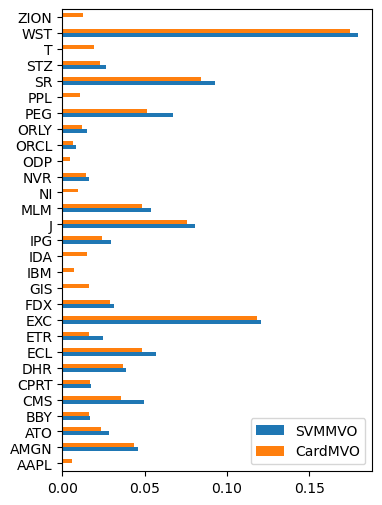

In [29]:
portfolios[(portfolios > 0.001).any(axis =1)].plot.barh(figsize = (4, 6));

# 3. Efficient Frontier

In [30]:
# solve min variance and store it, along with the expected return
from IPython.display import clear_output

plot_scaling = 0.5
NumPts = 10
StrategyCardMVO.investor_preferences['cardinality_ratio'] = 1
StrategyCardMVO.investor_preferences['premium'] = -1 * 10 ** 6
StrategyCardMVO.execute_strategy(periodReturns, periodFactRet, environment=env)
min_return = StrategyCardMVO.current_results['x']@StrategyCardMVO.current_estimates[0]
max_return  = plot_scaling*StrategyCardMVO.current_estimates[0].max()
max_premium = max_return/StrategyCardMVO.current_estimates[0].mean()
min_premium = min_return/StrategyCardMVO.current_estimates[0].mean()

path = "Experiments//EF//"+universe+"//"
if not os.path.exists(path):
    os.makedirs(path)
    print("Path created: ", path)

Set parameter TimeLimit to value 20
Set parameter MIPGap to value 0.05
Set parameter FeasibilityTol to value 1e-08
--------------------
Solving Card MVO...
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11.0 (22621.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 289 rows, 572 columns and 1430 nonzeros
Model fingerprint: 0x1fab0150
Model has 41041 quadratic objective terms
Variable types: 286 continuous, 286 integer (286 binary)
Coefficient statistics:
  Matrix range     [9e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [1e-05, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+05]
Found heuristic solution: objective 0.0890611
Presolve removed 288 rows and 286 columns
Presolve time: 0.01s
Presolved: 1 rows, 286 columns, 286 nonzeros
Presolved model has 41041 quadratic objective terms
Variable 

### Do not run here

In [31]:
vols_mvo, rets_mvo, premiums_mvo, cardinalities_mvo, mip_gaps, results = efficient_frontier_premium(StrategyCardMVO, max_return, min_return, NumPts, periodReturns, periodFactRet, env)
print("Cardinality ratio that binds ", cardinalities_mvo.max()/len(tickers)) #natural cardinality based on 0.1%
mvo_frontier_results = {}
mvo_frontier_results['MVO'] =  vols_mvo, rets_mvo, premiums_mvo, cardinalities_mvo, mip_gaps, results
export_dict(path, '', mvo_frontier_results, 'MVO')

Set parameter TimeLimit to value 20
Set parameter MIPGap to value 0.05
Cardinality ratio that binds  0.16083916083916083


In [32]:
cardinality_ratios = [0.02, 0.04, 0.06, 0.08, 0.1]
cardinality_frontier_results = {}

for cardinality_ratio in cardinality_ratios:
    StrategyCardMVO.investor_preferences['cardinality_ratio'] = cardinality_ratio
    cardinality_frontier_results[cardinality_ratio] = efficient_frontier_premium(StrategyCardMVO, max_return, min_return, NumPts, periodReturns, periodFactRet, env)
export_dict(path, '', cardinality_frontier_results, 'CardMVO')

Set parameter TimeLimit to value 20
Set parameter MIPGap to value 0.05


In [33]:
kappas =  [0.0125, 0.025, 0.05, 0.1, 0.2, 0.4, 0.8, 1.6]
svmmvo_frontier_results = {}
for cardinality_ratio in cardinality_ratios:
    for kappa in kappas:
        Strategy.investor_preferences['kappa'] = kappa
        Strategy.investor_preferences['cardinality_ratio'] = cardinality_ratio
        svmmvo_frontier_results[(cardinality_ratio, kappa)] = efficient_frontier_premium(Strategy, max_return, min_return, NumPts, periodReturns, periodFactRet, env)
export_dict(path, '', svmmvo_frontier_results, 'ClassWgtSVMMVO')

Set parameter TimeLimit to value 20
Set parameter MIPGap to value 0.05
Set parameter TimeLimit to value 20
Set parameter FeasibilityTol to value 1e-08
Set parameter TimeLimit to value 20
Set parameter FeasibilityTol to value 1e-08
Set parameter MIPGap to value 0.05



KeyboardInterrupt



# Analysis of Frontiers

In [ ]:
from services.experiments import *
mvo_frontier_results = import_dict(path, '', 'MVO')
cardinality_frontier_results = import_dict(path, '', 'CardMVO')
svmmvo_frontier_results = import_dict(path, '', 'ClassWgtSVMMVO')

cardinality = 0.06
cardinality_str = r"$K = \lfloor "+str(cardinality) + r"N \rfloor$"
kappa = 0.2
kappa_str = r"$\kappa = "+str(kappa*100)+r"\%$"

In [30]:
vols_mvo, rets_mvo, premiums_mvo, cardinalities_mvo, gaps_mvo, results_mvo = mvo_frontier_results['MVO']

NameError: name 'mvo_frontier_results' is not defined

In [31]:
rets_mvo

NameError: name 'rets_mvo' is not defined

In [247]:
vols_cardmvo, rets_cardmvo, premiums_cardmvo, cardinalities_cardmvo, gaps_cardmvo, results_cardmvo = cardinality_frontier_results[cardinality]

In [248]:
vols_svmmvo, rets_svmmvo, premiums_svmmvo, cardinalities_svmmvo, gaps_svmmvo, results_svmmvo = svmmvo_frontier_results[(cardinality, kappa)]

In [249]:
#tickers[(results_svmmvo[t]['optimization_params']['mu'] > 0.5).flatten()]

In [250]:
vols_svmmvo = np.array([results_svmmvo[t]['x']@results_svmmvo[t]['optimization_params']['Q']@results_svmmvo[t]['x']  for t in results_svmmvo.keys()])

In [251]:
# import matplotlib
# matplotlib.rc('text', usetex=True)
# matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

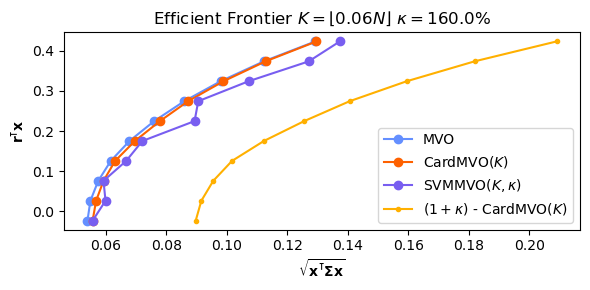

In [252]:
plt.figure(figsize = (6,3))
ax = plt.gca()
plt.plot(np.sqrt(vols_mvo), rets_mvo, 'o-',  label = 'MVO', color = '#648FFF')
plt.plot(np.sqrt(vols_cardmvo), rets_cardmvo, 'o-',  label = 'CardMVO($K$)', color = '#FE6100')
plt.plot(np.sqrt(vols_svmmvo), rets_svmmvo, 'o-', label = r"SVMMVO($K, \kappa$)", color = '#785EF0')
plt.plot(np.sqrt((1+kappa)*vols_cardmvo), rets_cardmvo, '.-', label = r"$(1 + \kappa)$ - CardMVO($K$)", color = '#FFB000')
plt.title("Efficient Frontier "+cardinality_str + " "+ kappa_str)
plt.xlabel(r'$\sqrt{\bf{x}^{\intercal} \bf{\Sigma} \bf{x}}$')
plt.ylabel(r'$\bf{r}^{\intercal} \bf{x}$')
plt.tight_layout()
plt.legend()
plt.savefig(path+"frontier_"+str(cardinality).replace(".","dot")+"_"+str(kappa).replace(".","dot") +".svg")

In [253]:
print("Candidates to display")
for t in results_svmmvo.keys():
    t_vals = results_svmmvo[t]['t']
    if np.sum(np.abs(results_svmmvo[t]['w'][t_vals > 0.99])) > 0.0001:
        print(t)

Candidates to display
0
1
2
3
4
5
6
7
8
9


In [272]:
t = 9

In [273]:
z_vals = np.rint(results_svmmvo[t]['z'])
z_vals_card_mvo = np.rint(results_cardmvo[t]['z'])
t_vals = results_svmmvo[t]['t']
w_vals = results_svmmvo[t]['w'][t_vals > 0.99]
b_val = results_svmmvo[t]['b']
ret_string = r'$r_{\mathsf{min}} = '+str(np.round(100*rets_svmmvo[t], 2)) + r'\%$'

In [274]:
from scipy import stats

context2d = results_svmmvo[t]['optimization_params']['period_Context'].iloc[:, t_vals > 0.99]
assets = (np.abs(stats.zscore(context2d)) < 100).all(axis=1)
z_vals_reduced = z_vals[assets]
z_vals_card_mvo_reduced = z_vals_card_mvo[assets]
context2d = context2d[assets]
#context2d  = context2d.rank()/(len(context2d)+1)
context2d[r'$\bf{z}$'] = '#FE6100'
context2d[r'$\bf{z}$'].iloc[z_vals_reduced > 0.01] = '#648FFF'

context2d[r'$\bf{z}_{\text{CardMVO}}$'] = '#ffffff'
different = np.abs(z_vals_reduced - z_vals_card_mvo_reduced)  > 0.1
context2d[r'$\bf{z}_{\text{CardMVO}}$'].iloc[different] = '#0e0f3b'

C:\Users\david\AppData\Local\Temp\ipykernel_15392\2920033590.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  context2d[r'$\bf{z}$'].iloc[z_vals_reduced > 0.01] = '#648FFF'
C:\Users\david\AppData\Local\Temp\ipykernel_15392\2920033590.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  context2d[r'$\bf{z}_{\text{CardMVO}}$'].iloc[different] = '#0e0f3b'


In [278]:
line = create_linear_function(w_vals, b_val)
x = np.array([-2, 2])

In [279]:
line(x)

array([ 2.91073265, -0.08827442])

File name : Experiments//EF//SP//features_0dot06_1dot69.svg


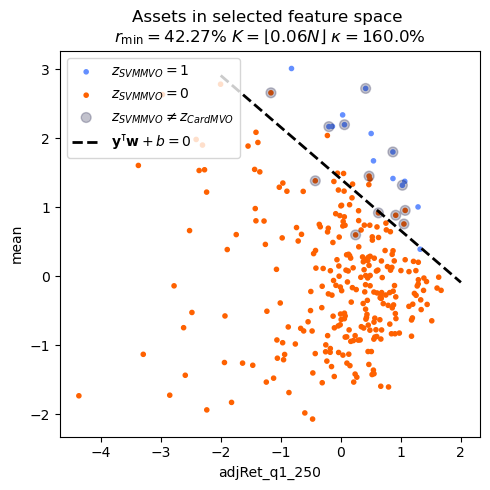

In [280]:
plt.figure(figsize = (5,5))
ax = plt.gca()
eligible = z_vals_reduced > 0.01


plt.scatter(context2d.iloc[eligible ,0], context2d.iloc[eligible ,1], c = context2d.iloc[eligible ,2].values, label= r'$z_{SVMMVO} = 1$', marker = '.')
plt.scatter(context2d.iloc[~eligible,0], context2d.iloc[~eligible,1], c = context2d.iloc[~eligible,2].values, label= r'$z_{SVMMVO} = 0$', marker = '.')
plt.scatter(context2d.iloc[different,0], context2d.iloc[different,1], c = context2d.iloc[different,3].values, s = 50, alpha = 0.25,
            marker = 'o', label = r'$z_{SVMMVO} \neq z_{CardMVO}$')
#context2d.plot.scatter(x = 0, y = 1, c = 2, ax = ax)
plt.plot(x, line(x), '--', linewidth = 2, label = r'${\bf{y}^{\intercal}\bf{w}} + b = 0$', color ='black')
plt.xlabel(context2d.columns[0])
plt.ylabel(context2d.columns[1])
plt.title("Assets in selected feature space \n"+ ret_string + " " +cardinality_str + " "+ kappa_str)
plt.legend(loc = 'upper left')
plt.tight_layout()
print("File name :", path+"features_"+str(cardinality).replace(".","dot")+"_"+str(kappa).replace(".","dot")+str(t) +".svg")
plt.savefig(path+"features_"+str(cardinality).replace(".","dot")+"_"+str(kappa).replace(".","dot")+str(t) +".svg")

In [271]:
Strategy.investor_preferences['premium'] = premiums_svmmvo[t]
Strategy.investor_preferences['cardinality_ratio'] = cardinality
Strategy.investor_preferences['kappa'] = kappa

StrategyCardMVO.investor_preferences['premium'] = premiums_svmmvo[t]
StrategyCardMVO.investor_preferences['cardinality_ratio'] = cardinality
StrategyCardMVO.investor_preferences['kappa'] = kappa

Strategy.execute_strategy(periodReturns, periodFactRet, environment=env)
StrategyCardMVO.execute_strategy(periodReturns, periodFactRet, environment=env)

Class weighted SVM
--------------------
Calculating Big M
--------------------
Constructing Feasible Solution...
Extracting a cardinality constrained portfolio...
Set parameter TimeLimit to value 20
Set parameter MIPGap to value 0.05
Set parameter FeasibilityTol to value 1e-08
Set parameter SolutionLimit to value 20
--------------------
Solving Card MVO...
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11.0 (22621.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 289 rows, 572 columns and 1430 nonzeros
Model fingerprint: 0x5ef36541
Model has 41041 quadratic objective terms
Variable types: 286 continuous, 286 integer (286 binary)
Coefficient statistics:
  Matrix range     [9e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [1e-05, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-01, 2e+01]
Presolve tim

array([0.01220791, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.02913787, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.04350745, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.0650743 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.05183573, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.03476366, 0.        , 0.     

In [147]:
z_vals = np.rint(Strategy.current_results['z'])
t_vals = Strategy.current_results['t']
w_vals = Strategy.current_results['w'][t_vals > 0.99]
b_val = Strategy.current_results['b']

context2d = Strategy.current_results['optimization_params']['period_Context'].iloc[:, t_vals > 0.99]
assets = (np.abs(stats.zscore(context2d)) < 100).all(axis=1)
z_vals_reduced = z_vals[assets]
context2d = context2d[assets]
#context2d  = context2d.rank()/(len(context2d)+1)
context2d[r'$\bf{z}$'] = '#FE6100'
context2d[r'$\bf{z}$'].iloc[z_vals_reduced > 0.01] = '#648FFF'

line2 = create_linear_function(w_vals, b_val)

C:\Users\david\AppData\Local\Temp\ipykernel_19712\263986914.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  context2d[r'$\bf{z}$'].iloc[z_vals_reduced > 0.01] = '#648FFF'


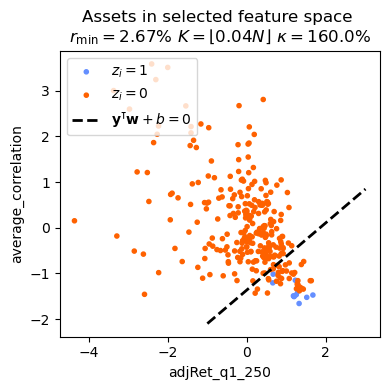

In [148]:
plt.figure(figsize = (4,4))
ax = plt.gca()
eligible = z_vals_reduced > 0.01
plt.scatter(context2d.iloc[eligible ,0], context2d.iloc[eligible ,1], c = context2d.iloc[eligible ,2].values, label= r'$z_i = 1$', marker = '.')
plt.scatter(context2d.iloc[~eligible,0], context2d.iloc[~eligible,1], c = context2d.iloc[~eligible,2].values, label= r'$z_i = 0$', marker = '.')
#context2d.plot.scatter(x = 0, y = 1, c = 2, ax = ax)
#plt.plot(x, line(x), '--', linewidth = 2, label = r'${\bf{y}^{\intercal}\bf{w}} + b = 0$', color ='black')
plt.plot(x, line2(x), '--', linewidth = 2, label = r'${\bf{y}^{\intercal}\bf{w}} + b = 0$', color ='black')

plt.xlabel(context2d.columns[0])
plt.ylabel(context2d.columns[1])
plt.title("Assets in selected feature space \n"+ ret_string + " " +cardinality_str + " "+ kappa_str)
plt.legend(loc = 'upper left')
plt.tight_layout()
plt.savefig(path+"features_"+str(cardinality).replace(".","dot")+"_"+str(kappa).replace(".","dot")+str(t) +".svg")